# **EDA Sample Instalments Payments**

## **Table of contents**
* [Our goals](#Our-goals)
* [About the data](#About-the-data)
* [Generalities](#Generalities)
* [Missing values](#Missing-values)
* [Raw features description](#Raw-features-description)
* [Features creation](#Features-creation)
* [Summary](#Summary)

In [1]:
import sys
import os
from pathlib import Path

project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    stat_utilities,
    plot_utilities
)

from utilities.stat_utilities import get_missing_values
from utilities.plot_utilities import (
    to_percent, 
    plot_triangle_corr_matrix, 
    Rstyle_spines
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
data_dir = "../sample_data/"

In [3]:
sample_instal = pd.read_parquet(data_dir + "sample_installments_payments.parquet")

## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
    
In this notebook we aim at:
* **Exploring the Installment Dataset:** Perform EDA to identify potential anomalies.
* **Creating New Features:** Apply two-stage aggregation on SK_ID_PREV and SK_ID_CURR.
* **Building Functions:** Create functions to compute new features and join them with the main dataframe.
* **Visualizing Relationships:** Visualize how the features relate to each other.
</div>

## **About the data**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
This dataset contains a detailed list of every transaction (instalment) made by the loan applicant to Home Credit for some of the loans he has contracted.
</div>

## **Generalities**

In [4]:
sample_instal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2327178 entries, 3 to 13605387
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int32  
 1   SK_ID_CURR              int32  
 2   NUM_INSTALMENT_VERSION  float32
 3   NUM_INSTALMENT_NUMBER   int16  
 4   DAYS_INSTALMENT         float32
 5   DAYS_ENTRY_PAYMENT      float32
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float32(3), float64(2), int16(1), int32(2)
memory usage: 102.1 MB


## **Missing values**

In [5]:
get_missing_values(sample_instal)

,Count,Percent
DAYS_ENTRY_PAYMENT,498,0.021399
AMT_PAYMENT,498,0.021399
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000
NUM_INSTALMENT_NUMBER,0,0.000000
DAYS_INSTALMENT,0,0.000000
AMT_INSTALMENT,0,0.000000


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
There are only a few missing values in both `DAYS_ENTRY_PAYMENT` and `AMT_PAYMENT`. These missing values can come, for example, from the recent nature of the loan. We can find very natural and logical ways to impute them. For instance, for `DAYS_ENTRY_PAYMENT`, we can impute missing values with the corresponding` DAYS_INSTALMENT`, assuming the payment was made on time. Similarly, for AMT_PAYMENT, we could impute the missing values with AMT_INSTALMENT, assuming the full payment is expected. We'll verify if these assumptions are supported by the data.
</div>

Text(0.5, 1.0, 'Distribution of AMT_INSTALMENT - AMT_PAYMENT')

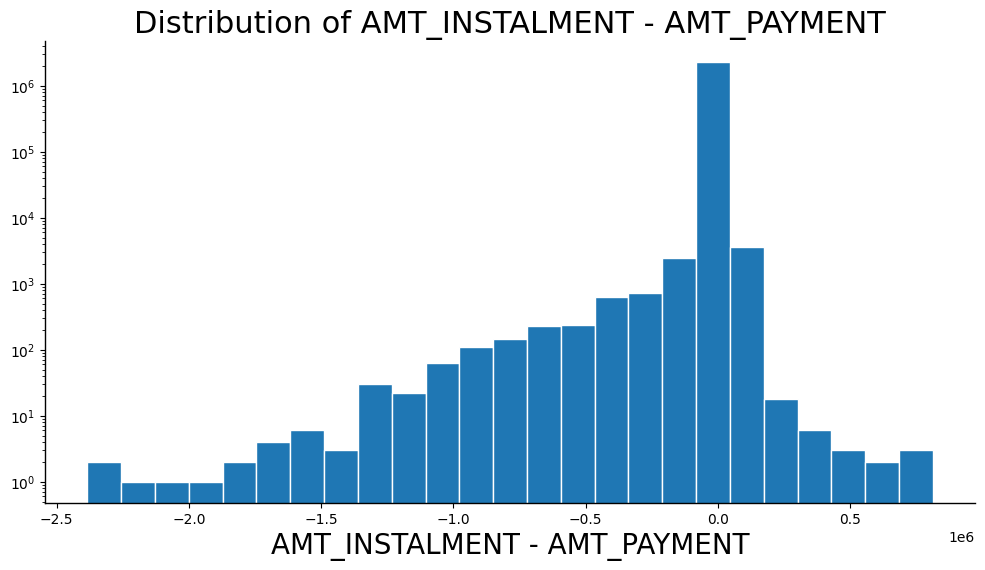

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_yscale("log")
ax.hist(
    sample_instal["AMT_INSTALMENT"] - sample_instal["AMT_PAYMENT"],
    bins=25,
    color="C0",
    edgecolor="w",
)
Rstyle_spines(ax, lw=1)
ax.set_xlabel("AMT_INSTALMENT - AMT_PAYMENT", fontsize=20)
ax.set_title("Distribution of AMT_INSTALMENT - AMT_PAYMENT", fontsize=22)

In [7]:
(
    100
    * (sample_instal["AMT_INSTALMENT"] - sample_instal["AMT_PAYMENT"]).value_counts()
    / sample_instal.shape[0]
)

 0.000        89.125928
 2250.000      0.069097
 4500.000      0.052553
 1125.000      0.031841
 6750.000      0.027028
                ...    
 4905.585      0.000043
-11501.460     0.000043
-3997.080      0.000043
 1083.240      0.000043
 8965.620      0.000043
Name: count, Length: 167331, dtype: float64

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
In nearly 90% of the cases, the borrowers pay the expected amount, meaning `AMT_INSTALMENT` and `AMT_PAYMENT` are equal. Given this strong pattern, we can reasonably assume that the missing values for `AMT_PAYMENT` represent payments made in full. This assumption simplifies our imputation strategy, allowing us to replace missing values with the corresponding `AMT_INSTALMENT` amounts.
</div>

In [8]:
sample_instal["AMT_PAYMENT"] = sample_instal["AMT_PAYMENT"].fillna(
    sample_instal["AMT_INSTALMENT"]
)

Text(0.5, 1.0, 'Distribution of DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT')

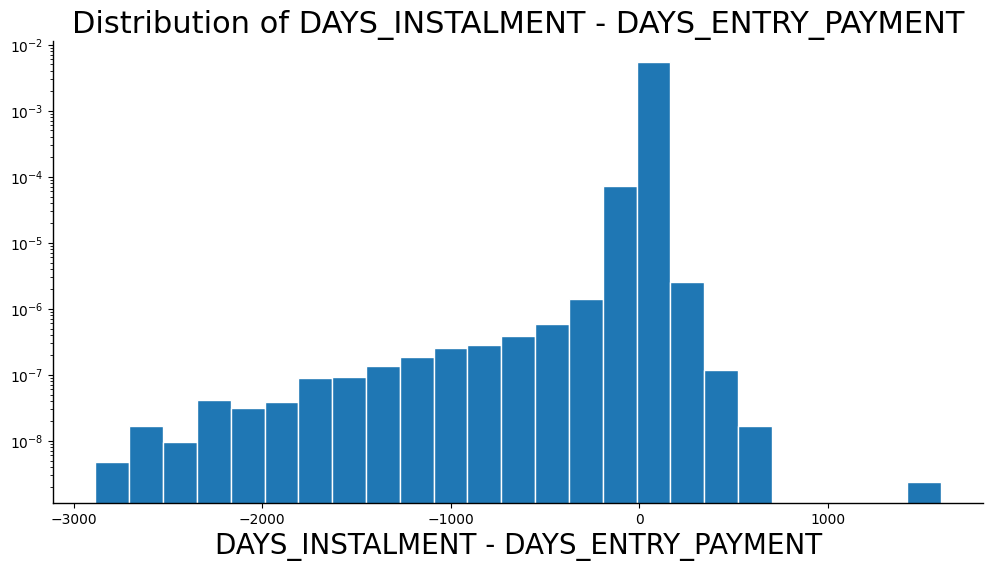

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_yscale("log")
ax.hist(
    sample_instal["DAYS_INSTALMENT"] - sample_instal["DAYS_ENTRY_PAYMENT"],
    density=True,
    bins=25,
    color="C0",
    edgecolor="w",
)
Rstyle_spines(ax, lw=1)
ax.set_xlabel("DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT", fontsize=20)
ax.set_title("Distribution of DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT", fontsize=22)

In [10]:
(
    100
    * (
        sample_instal["DAYS_INSTALMENT"] - sample_instal["DAYS_ENTRY_PAYMENT"]
    ).value_counts()
    / sample_instal.shape[0]
)

 0.0       23.158521
 1.0        3.841219
 2.0        3.727433
 3.0        3.356598
 9.0        3.322092
             ...    
-1101.0     0.000043
-502.0      0.000043
-782.0      0.000043
-1062.0     0.000043
 339.0      0.000043
Name: count, Length: 1354, dtype: float64

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
For `DAYS_ENTRY_PAYMENT`, the situation is less clear-cut, but the majority of borrowers still make their payments on time. Therefore, we'll impute the missing values in `DAYS_ENTRY_PAYMENT` with the corresponding values from `DAYS_INSTALMENT`, assuming that the payments were made on the scheduled due date.
</div>

In [11]:
sample_instal["DAYS_ENTRY_PAYMENT"] = sample_instal["DAYS_ENTRY_PAYMENT"].fillna(
    sample_instal["DAYS_INSTALMENT"]
)

## **Raw features description**

In [12]:
ins_num_cols = [
    col
    for col in sample_instal.select_dtypes(include="number").columns
    if not col.startswith("SK_ID")
]

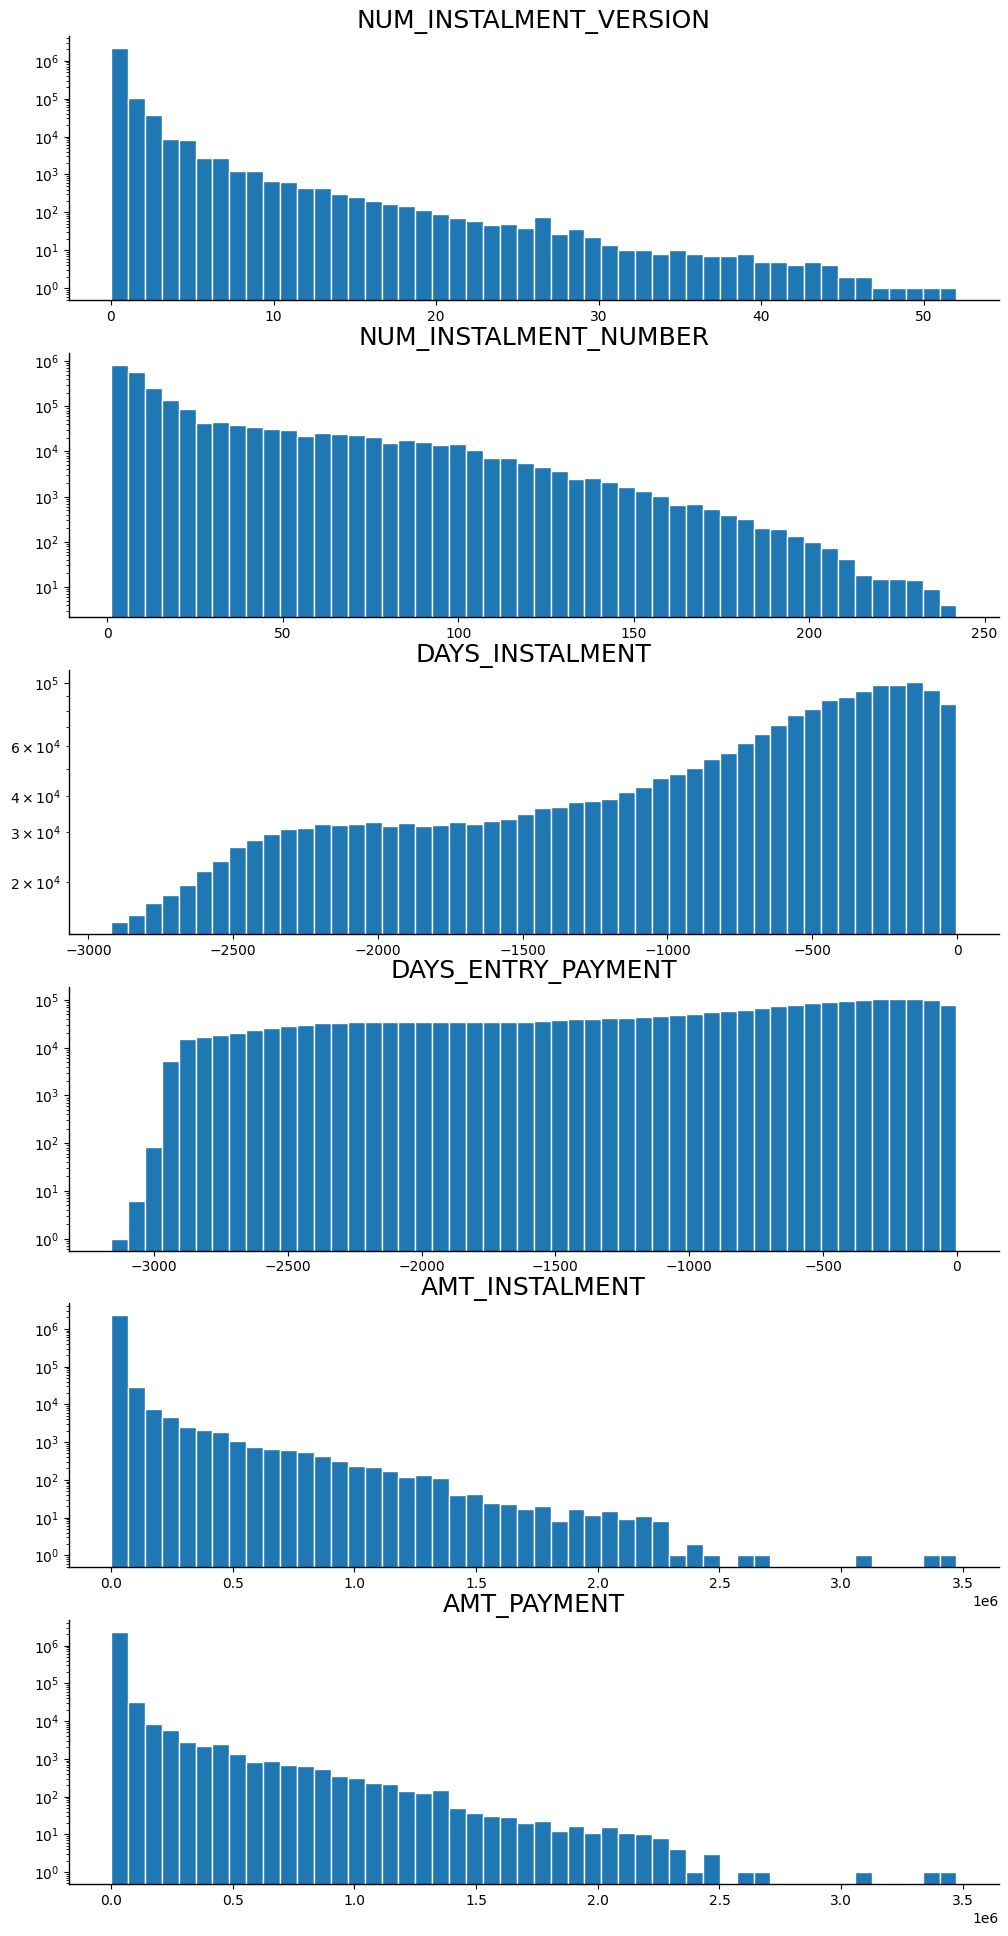

In [13]:
fig, axs = plt.subplots(len(ins_num_cols), 1, figsize=(12, 4 * len(ins_num_cols)))
for i, feature in enumerate(ins_num_cols):
    N, bins, patches = axs[i].hist(
        sample_instal[feature], bins=50, color="C0", edgecolor="w"
    )
    axs[i].set_yscale("log")
    axs[i].set_title(feature, fontsize=18)
    Rstyle_spines(axs[i], lw=1)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
There isn't much to say about the features; no obvious anomalies have been detected so far. It would be more interesting to examine the newly created features, as this will allow us to observe how they relate to the target variable.
</div>

## **Features creation**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
To move forward with feature engineering from the instalments payments dataset, we will design a function that first cleans the data, and then applies two layers of aggregation over `SK_ID_PREV` (individual loans) and `SK_ID_CURR` (loan applicants). We'll generate new features that capture meaningful patterns in repayment behavior, which are likely to help our model predict defaults.
Here are the features we plan to create:

* **Features:**
    * **Difference between `AMT_INSTALMENT` and `AMT_PAYMENT`:**
        * **Concept:** This will measure the extent to which the borrower is able to repay the loan instalments fully.
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Sum (**SUM**) the differences between `AMT_INSTALMENT` and `AMT_PAYMENT` for each loan, and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**) and the sum (**SUM**)
    * **Timeliness of Payments (`DAYS_INSTALMENT` vs. `DAYS_ENTRY_PAYMENT`):**
        * **Concept:** This measures whether the payments were made on time, and whether they were delayed or paid early.
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Sum the delays or early payments (i.e., `DAYS_INSTALMENT` - `DAYS_ENTRY_PAYMENT`) for each loan and this over different time windows: **EVER**, **LAST_YEAR** and **LAST_3_MONTHS**.
            * **Step 2 (`SK_ID_CURR`):** For each applicant, aggregate this information using the mean (**AVG**) and the sum (**SUM**)
    * **Number of Changes in Instalment Version (`NUM_INSTALMENT_VERSION`):**
        * **Concept:** This will count how many times the instalment plan (or structure) was changed during the loan period, which could indicate payment difficulties.
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Count the number (**CNT**) of unique `NUM_INSTALMENT_VERSION` values for each loan.
            * **Step 2 (`SK_ID_CURR`):** Sum (**SUM**) and average (**AVG**) the number of changes across all loans for each applicant.
    * **Number of Instalments (`NUM_INSTALMENT_NUMBER`):** This will indicate how many instalments the loan applicant had paid up until they took out a loan from Home Credit.
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Take the maximum (**MAX**) number of `NUM_INSTALMENT_NUMBER` values for each loan.
            * **Step 2 (`SK_ID_CURR`):** Sum (**SUM**), average (**AVG**) and get the maximum (**MAX**) of this number across all loans for each applicant.
    * **Oldest and Most Recent Instalments (`DAYS_ENTRY_PAYMENT`)**: This will tell us when was the first and the last payments ever made by the loan applicant
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Take the maximum (**MAX**) and the minimum (**MIN**) of `DAYS_ENTRY_PAYMENT` values for each loan.
            * **Step 2 (`SK_ID_CURR`):** Take the average (**AVG**), the maximum (**MAX**), and minimum (**MIN**) of this number across all loans for each applicant.
    * **Maximum and Average Payments (`AMT_PAYMENT`):** This will provide information about the average and highest payments ever made by the loan applicant.
        * **Aggregation Strategy:**
            * **Step 1 (`SK_ID_PREV`):** Take the maximum (**MAX**) and the average (**AVG**) of `AMT_PAYMENT` values for each loan.
            * **Step 2 (`SK_ID_CURR`):** Compute the average (**AVG**) and find the maximum (**MAX**) of this number across all loans for each applicant.

        
All this should take place within a function that will, in order, do:
* **Data Cleaning:** Handle missing values and anomalies based on previous EDA insights (e.g., converting invalid values to NaN, dropping unnecessary rows).
* **Aggregation:** Perform first (`SK_ID_PREV`) and second (`SK_ID_CURR`) aggregations.
* **Output:** The function will return a dataframe with the new features, ready to be joined with the main datframe.

This feature engineering step will create new variables that capture deeper insights into loan repayment behavior. These features are expected to improve the classifier’s performance by adding nuanced information about the financial habits of loan applicants. The function must be adaptable for integration into a full preprocessing pipeline within scikit-learn.
</div>

In [14]:
def cleaning_df_instal(df_instal: pd.DataFrame) -> pd.DataFrame:
    df_instal["AMT_PAYMENT"] = df_instal["AMT_PAYMENT"].fillna(
        df_instal["AMT_INSTALMENT"]
    )
    df_instal["DAYS_ENTRY_PAYMENT"] = df_instal["DAYS_ENTRY_PAYMENT"].fillna(
        df_instal["DAYS_INSTALMENT"]
    )
    return df_instal

In [15]:
def compute_first_agg_instal(df_instal: pd.DataFrame) -> pd.DataFrame:
    # We will now proceed to the first aggregation, this one will take place over SK_ID_PREV
    # We first compute the differences, and create two new features within our dataset
    df_instal["DIFF_AMT_INSTALMENT_PAYMENT"] = (
        df_instal["AMT_INSTALMENT"] - df_instal["AMT_PAYMENT"]
    )
    df_instal["DIFF_DAYS_INSTALMENT_PAYMENT"] = (
        df_instal["DAYS_INSTALMENT"] - df_instal["DAYS_ENTRY_PAYMENT"]
    )

    # We'll start with non-temporal features
    agg_dict_all = {
        "NUM_INSTALMENT_VERSION": ["nunique"],
        "NUM_INSTALMENT_NUMBER": ["max"],
        "DAYS_ENTRY_PAYMENT": ["max", "min"],
        "AMT_PAYMENT": ["max", "mean"],
    }
    features_all = df_instal.groupby(["SK_ID_PREV", "SK_ID_CURR"]).agg(agg_dict_all)
    features_all.columns = [
        "_".join(col).upper() for col in features_all.columns.values
    ]

    # Now we can proceed with the temporal ones
    time_windows = [
        ("EVER", df_instal),
        ("LAST_YEAR", df_instal[df_instal["DAYS_ENTRY_PAYMENT"].between(-365, -92)]),
        ("LAST_3_MONTHS", df_instal[df_instal["DAYS_ENTRY_PAYMENT"] > -92]),
    ]
    diff_features = []
    for window_name, window_df in time_windows:
        agg_dict_diff = {
            "DIFF_AMT_INSTALMENT_PAYMENT": ["sum"],
            "DIFF_DAYS_INSTALMENT_PAYMENT": ["sum"],
        }
        window_features = window_df.groupby(["SK_ID_PREV", "SK_ID_CURR"]).agg(
            agg_dict_diff
        )
        window_features.columns = [
            f"{col[0]}_{window_name.upper()}_{col[1].upper()}"
            for col in window_features.columns.values
        ]
        diff_features.append(window_features)

    # We can combine all the features, reset the index, fill the missing values for the temporal features by 0 and drop the SK_ID_PREV
    first_agg_features = (
        features_all.join(diff_features)
        .fillna(0)
        .reset_index()
        .drop("SK_ID_PREV", axis=1)
    )

    return first_agg_features

In [16]:
def compute_second_agg_instal(first_agg_features: pd.DataFrame) -> pd.DataFrame:
    # Define aggregation operations for each group of features
    agg_ops = {
        # Temporal features (diff amount and diff days for each period)
        "DIFF_AMT_INSTALMENT_PAYMENT_EVER_SUM": ["mean", "sum"],
        "DIFF_DAYS_INSTALMENT_PAYMENT_EVER_SUM": ["mean", "sum"],
        "DIFF_AMT_INSTALMENT_PAYMENT_LAST_YEAR_SUM": ["mean", "sum"],
        "DIFF_DAYS_INSTALMENT_PAYMENT_LAST_YEAR_SUM": ["mean", "sum"],
        "DIFF_AMT_INSTALMENT_PAYMENT_LAST_3_MONTHS_SUM": ["mean", "sum"],
        "DIFF_DAYS_INSTALMENT_PAYMENT_LAST_3_MONTHS_SUM": ["mean", "sum"],
        # Number of changes in installment version
        "NUM_INSTALMENT_VERSION_NUNIQUE": ["mean", "sum"],
        # Number of installments
        "NUM_INSTALMENT_NUMBER_MAX": ["mean", "sum", "max"],
        # Oldest and most recent installments
        "DAYS_ENTRY_PAYMENT_MAX": ["mean", "max", "min"],
        "DAYS_ENTRY_PAYMENT_MIN": ["mean", "max", "min"],
        # Average and max payment
        "AMT_PAYMENT_MEAN": ["mean", "max"],
        "AMT_PAYMENT_MAX": ["mean", "max"],
    }

    # Perform the second aggregation
    second_agg_features = first_agg_features.groupby("SK_ID_CURR").agg(agg_ops)
    second_agg_features.columns = [
        "INSTAL_" + "_".join(col).upper() for col in second_agg_features.columns.values
    ]

    return second_agg_features.reset_index()

In [17]:
def compute_features_instal(df_instal: pd.DataFrame) -> pd.DataFrame:
    df_instal_ = df_instal.copy()

    # Clean the dataset
    df_instal_ = cleaning_df_instal(df_instal_)

    # Compute the first agg features (over SK_ID_PREV)
    first_agg = compute_first_agg_instal(df_instal_)

    # Compute the second agg features (over SK_ID_CURR)
    second_agg = compute_second_agg_instal(first_agg)

    # Reset the index to be SK_ID_CURR
    second_agg.set_index("SK_ID_CURR", inplace=True)

    return second_agg

In [18]:
instal_features = compute_features_instal(sample_instal)
instal_features.head(5)

,INSTAL_DIFF_AMT_INSTALMENT_PAYMENT_EVER_SUM_MEAN,INSTAL_DIFF_AMT_INSTALMENT_PAYMENT_EVER_SUM_SUM,INSTAL_DIFF_DAYS_INSTALMENT_PAYMENT_EVER_SUM_MEAN,INSTAL_DIFF_DAYS_INSTALMENT_PAYMENT_EVER_SUM_SUM,INSTAL_DIFF_AMT_INSTALMENT_PAYMENT_LAST_YEAR_SUM_MEAN,INSTAL_DIFF_AMT_INSTALMENT_PAYMENT_LAST_YEAR_SUM_SUM,INSTAL_DIFF_DAYS_INSTALMENT_PAYMENT_LAST_YEAR_SUM_MEAN,INSTAL_DIFF_DAYS_INSTALMENT_PAYMENT_LAST_YEAR_SUM_SUM,INSTAL_DIFF_AMT_INSTALMENT_PAYMENT_LAST_3_MONTHS_SUM_MEAN,INSTAL_DIFF_AMT_INSTALMENT_PAYMENT_LAST_3_MONTHS_SUM_SUM,...,INSTAL_DAYS_ENTRY_PAYMENT_MAX_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MAX_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MIN_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MIN_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MIN_MIN,INSTAL_AMT_PAYMENT_MEAN_MEAN,INSTAL_AMT_PAYMENT_MEAN_MAX,INSTAL_AMT_PAYMENT_MAX_MEAN,INSTAL_AMT_PAYMENT_MAX_MAX
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100003,0.000,0.000,59.666668,179.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1063.333374,-544.0,-1985.0,-1283.000000,-719.0,-2324.0,78558.479286,164425.332857,210713.44500,560835.360
100026,0.000,0.000,37.500000,75.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-840.000000,-425.0,-1255.0,-924.500000,-440.0,-1409.0,214993.590000,406391.580000,396806.40000,770004.315
100030,0.000,0.000,65.500000,131.0,0.0,0.0,52.0,104.0,0.0,0.0,...,-1525.500000,-233.0,-2818.0,-1596.000000,-374.0,-2818.0,13866.381000,16934.985000,17390.56500,17846.145
100039,-196729.095,-590187.285,127.000000,381.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1467.666626,-468.0,-2297.0,-1615.666626,-695.0,-2375.0,72009.584773,204462.486818,312828.48000,920794.500
100043,13234.860,52939.440,403.250000,1613.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-756.000000,-13.0,-2190.0,-1141.750000,-13.0,-2389.0,16653.655462,25972.965000,144832.78125,316290.690


<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

We have computed various features from the installment dataset. In the final pipeline, this newly created dataset will be merged with the main one, along with other datasets. Of course, some loan applicants may not yet have a loan with Home Credit, so they might be missing (i.e., no `SK_ID_CURR`). In such cases, the features we've created can easily be imputed with 0 for absent applicants.

Next, we'll explain and demonstrate how this step will be implemented in the future. Our pipeline needs to be both flexible and efficient, ensuring we only extract the necessary amount of information. For example, if we take a slice of the main dataframe (say, for cross-validation), we will extract the corresponding slice from other datasets. To achieve this, we will identify the `SK_ID_CURR` values from the main dataframe and retrieve only the relevant rows containing these `SK_ID_CURR` values in the other datasets. However, since our sample datasets were created specifically for this purpose, we'll simply demonstrate the process of pre-joining and joining. This way, we can observe how the newly created features relate to each other as well as to the target variable.
</div>

In [19]:
def join_instal_with_app(
    app_df: pd.DataFrame, features_instal: pd.DataFrame
) -> pd.DataFrame:
    sk_id_curr = pd.DataFrame(index=app_df.index)
    pre_joined = sk_id_curr.join(features_instal, how="left").fillna(0)

    joined = app_df.join(pre_joined, how="left")
    return joined

In [20]:
sample_app = pd.read_parquet(
    data_dir + "sample_application.parquet", columns=["SK_ID_CURR", "TARGET"]
)
sample_app.set_index("SK_ID_CURR", inplace=True)
instal_and_target = join_instal_with_app(sample_app, instal_features)

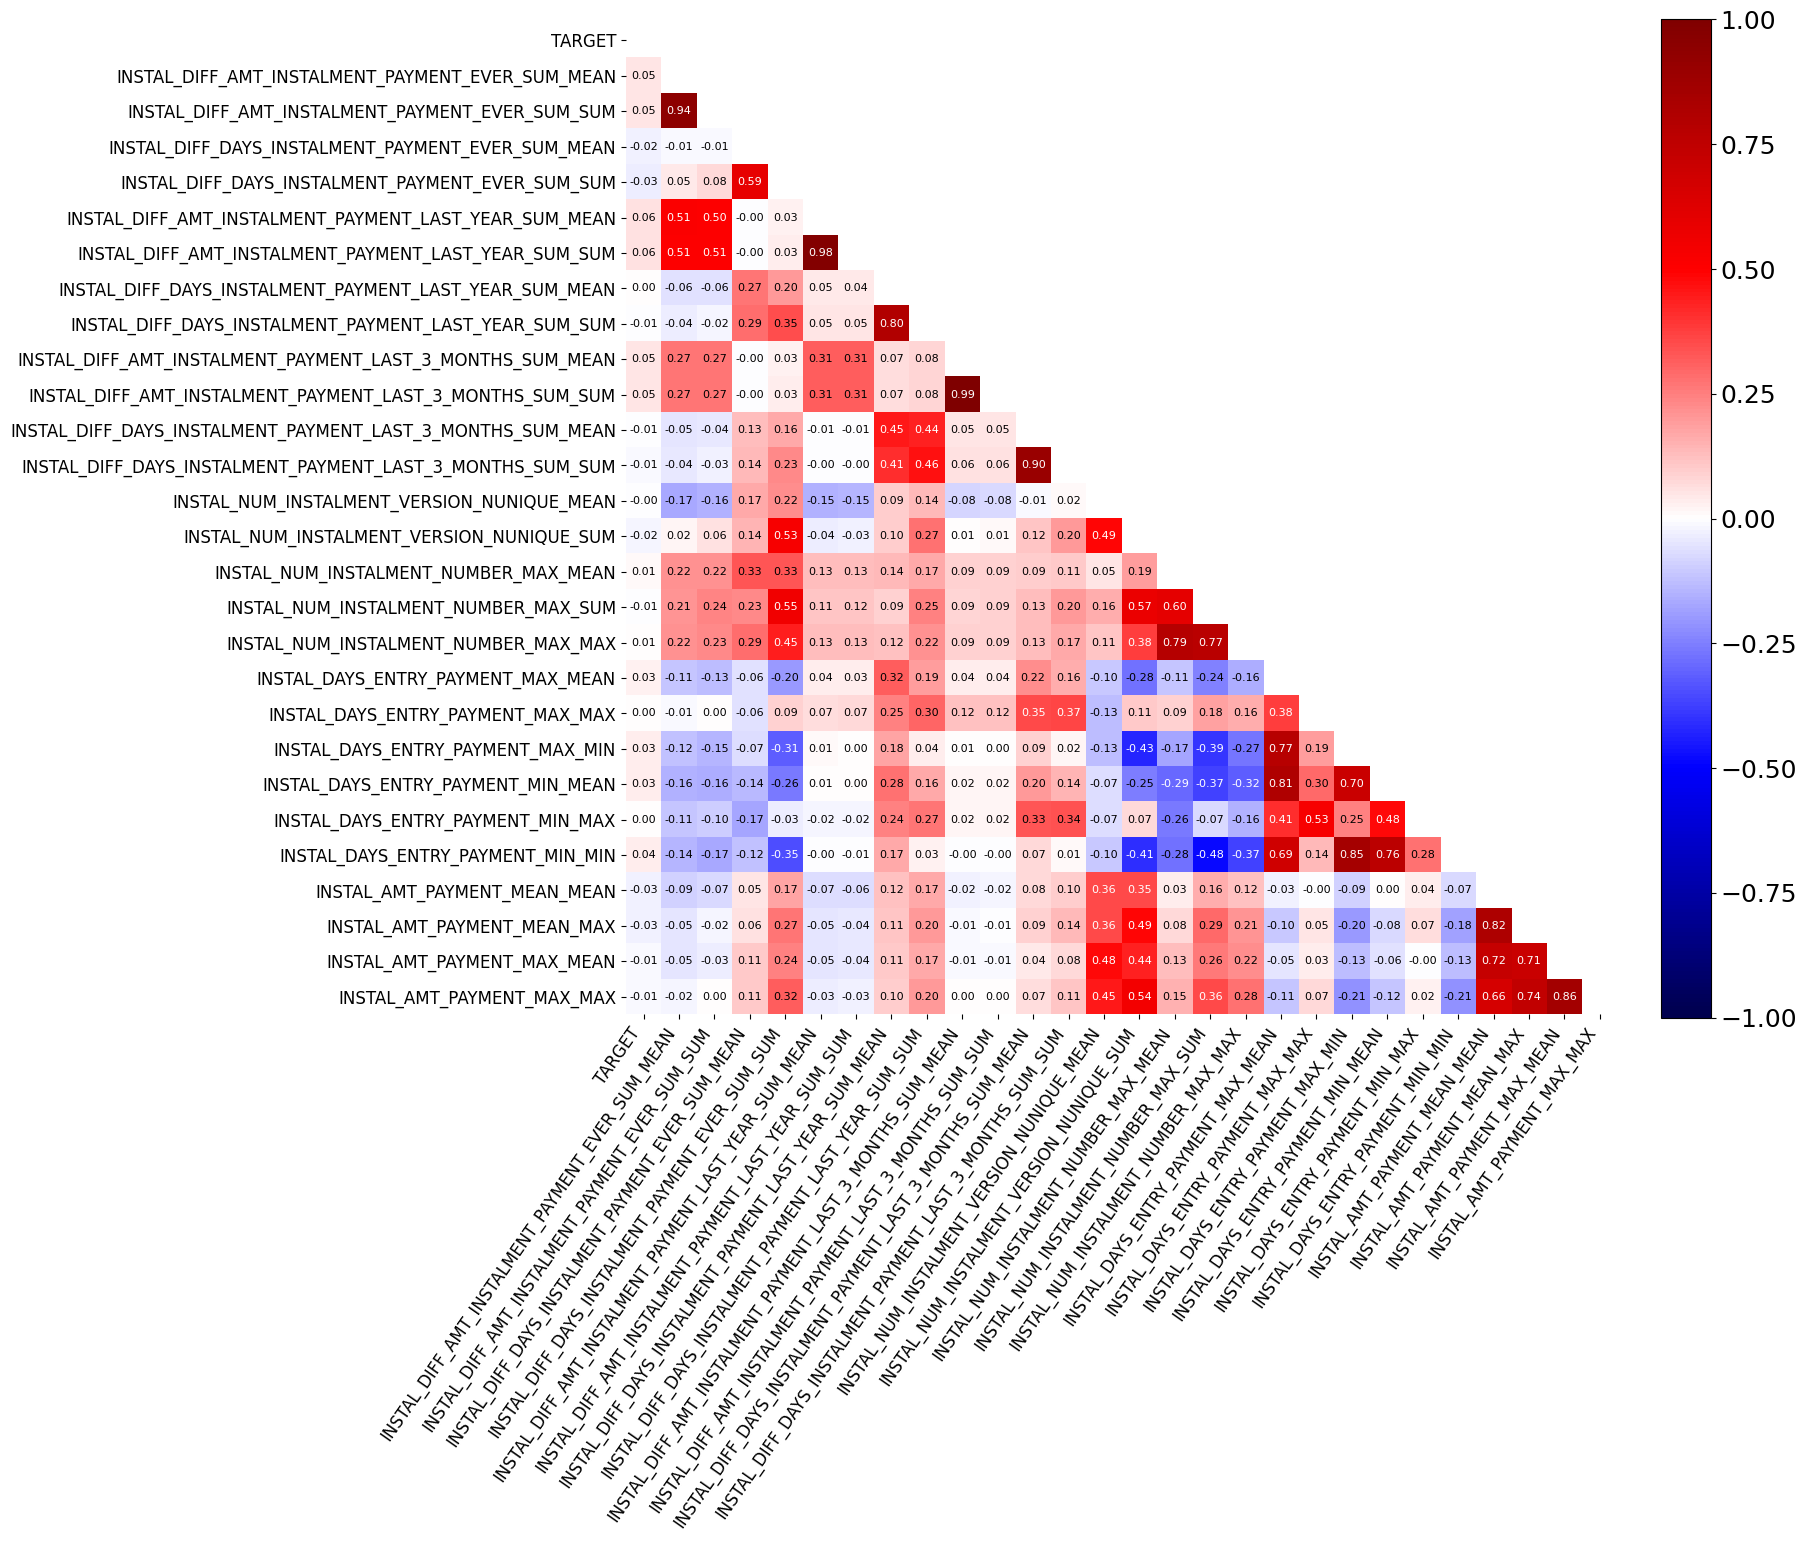

In [21]:
num_corr = instal_and_target.corr(method="kendall")
fig, ax = plt.subplots(figsize=(14, 14))
plot_triangle_corr_matrix(num_corr, ax=ax, ticks_fs=12, annotation=True, annot_fs=8)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">

A few observations should be noted:
* We've computed many features that show a lot of similarities, with some being nearly identical, as indicated by a Kendall correlation coefficient close to 1. We are aware that accumulating such features could slow down our pipeline and potentially lead to overfitting. For now, we will proceed by training our first model with all the features combined, and later, we'll perform feature selection where many of these redundant features may be removed.
* Some of the new features show a slight relationship with the target variable, which is a positive sign for validating our approach. However, it doesn't yet tell us how these features will interact with others during model training.
</div>

## **Summary**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
Here is a summary of our findings and actions:

* During the EDA, we identified some missing values in `DAYS_ENTRY_PAYMENT` and `AMT_PAYMENT`. We found a reasonable imputation strategy by assuming that payments were made in full and on time.
* We created 27 new features through a two-stage aggregation process. Some of these features are highly correlated with each other, which could pose issues later on (e.g., overfitting, reduced efficiency). However, a few show a small but noticeable correlation with the target variable, making them potentially valuable.
* We developed the functions that will be used to compute these features and merge them with the main dataframe in the final pipeline.
</div>